In [1]:
import pandas as pd
import nibabel as nib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import sfp 
import math
from scipy import stats
from scipy import optimize as opt
import torch
import glob
import os
import warnings
import itertools
import hessian
from torch.utils import data as torchdata

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
sns.set_style('whitegrid')
#df_path = "/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/first_level_analysis/stim_class/posterior/sub-wlsubj045/ses-04/sub-wlsubj045_ses-04_task-sfprescaled_v1_e1-12_summary.csv"
df_path = "/mnt/prince_scratch/spatial_frequency_preferences/derivatives/first_level_analysis/stim_class/bayesian_posterior/sub-wlsubj045/ses-04/sub-wlsubj045_ses-04_task-sfprescaled_v1_e1-12_summary.csv"

Failed to import duecredit due to No module named 'duecredit'


In this notebook, we investigate the results of fitting the 2d tuning model (see `05-Model.ipynb` for details of the model) to simulated data. We used simulated data:
1. to find the best learning hyperparameters
2. to confirm that we could recover the actual parameter values
3. that our cross-validation procedure found the generating model.

## Learning hyperparameters

There's a huge amount of information to wade through here, since I'm looking at 3 learning rates by 3 batch sizes by 2 true models by 2 fit models, with the goal of finding out what combination of learning rates, batch sizes, and thresholds make the most sense.

We're going to go with `batch_size=10`, `learning_rate=1e-3`, which finds the correct parameters (as long as that's possible) and finishes in a reasonable number of epochs. Compared to `batch_size=1`, each epoch is faster; this isn't enough to make it finish in a quicker amount of time, but it always finds the correct solution, which `batch_size=1` does not.

In [11]:
base_str = '/mnt/prince_scratch/spatial_frequency_preferences/derivatives/tuning_2d_simulated/noise-stim_class_bayesian_posterior_sub-wlsubj045_ses-02_task-sfp_v1_e1-12/learning_hyperparams_full/g0_all_'
models = pd.read_csv(base_str + 'models.csv')
model_history = pd.read_csv(base_str + 'model_history.csv')
timing_df = pd.read_csv(base_str + 'timing.csv')
avg_loss = pd.read_csv(base_str + 'loss.csv')
loss_df = pd.read_csv(base_str + 'diff.csv')

In [12]:
# hack to deal with this issue, hopefully fixed soon: https://github.com/mwaskom/seaborn/issues/1560
avg_loss.fit_model_type = avg_loss.fit_model_type.apply(lambda x: {'full_donut_full_amps-vary': 'full_donut_full_amps-vary ', 'full_donut_iso_amps-constant': 'full_donut_iso_amps-constant '}.get(x, x))
loss_df.fit_model_type = loss_df.fit_model_type.apply(lambda x: {'full_donut_full_amps-vary': 'full_donut_full_amps-vary ', 'full_donut_iso_amps-constant': 'full_donut_iso_amps-constant '}.get(x, x))
models.fit_model_type = models.fit_model_type.apply(lambda x: {'full_donut_full_amps-vary': 'full_donut_full_amps-vary ', 'full_donut_iso_amps-constant': 'full_donut_iso_amps-constant '}.get(x, x))
model_history.fit_model_type = model_history.fit_model_type.apply(lambda x: {'full_donut_full_amps-vary': 'full_donut_full_amps-vary ', 'full_donut_iso_amps-constant': 'full_donut_iso_amps-constant '}.get(x, x))
timing_df.fit_model_type = timing_df.fit_model_type.apply(lambda x: {'full_donut_full_amps-vary': 'full_donut_full_amps-vary ', 'full_donut_iso_amps-constant': 'full_donut_iso_amps-constant '}.get(x, x))

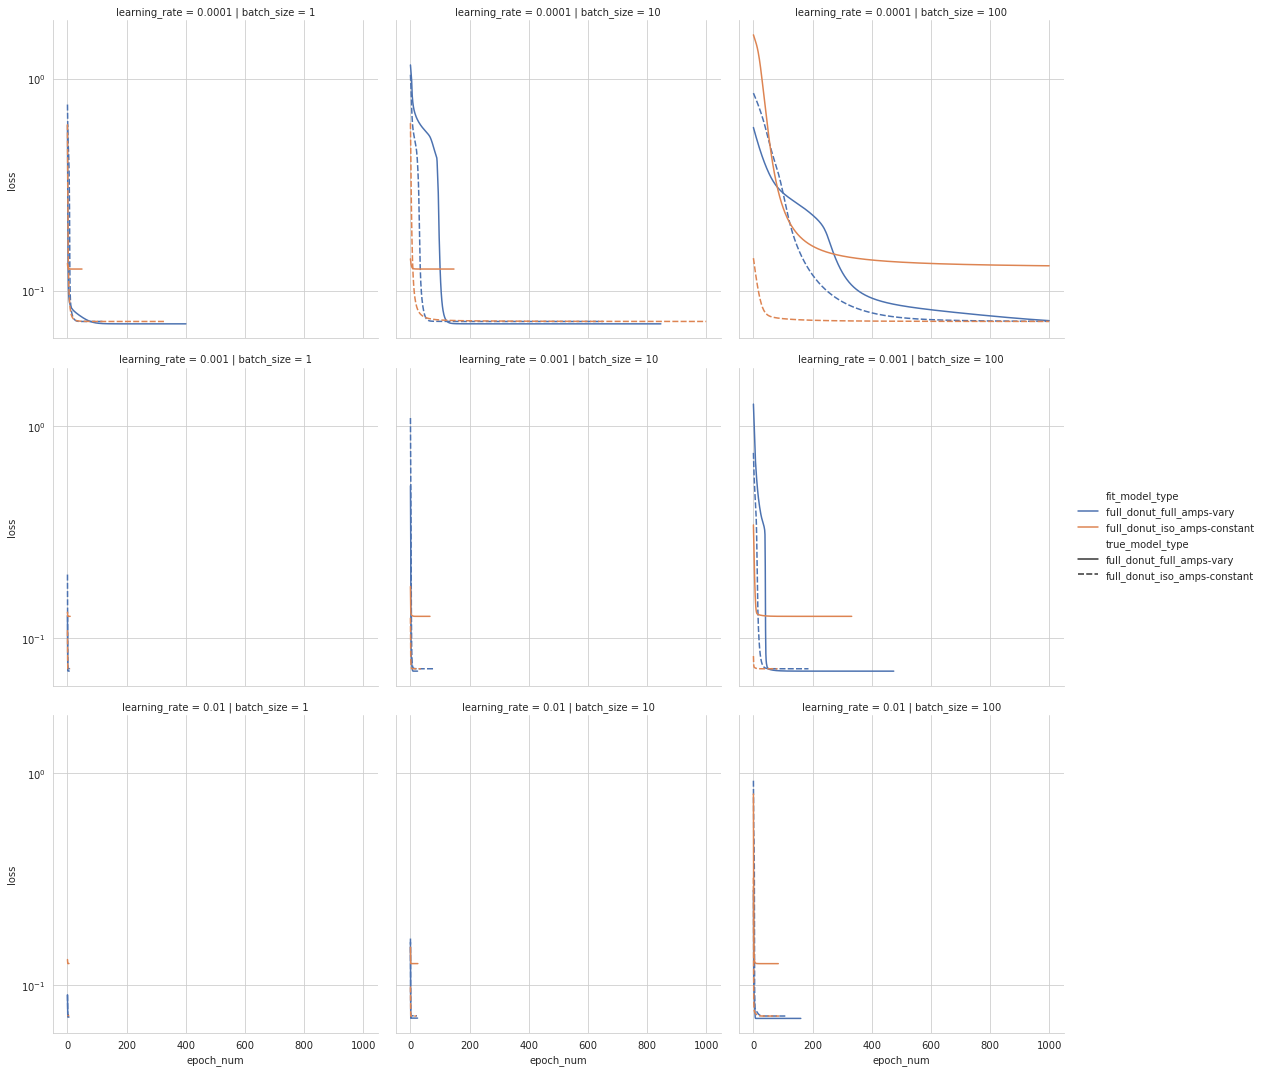

In [13]:
g = sns.relplot('epoch_num', 'loss', 'fit_model_type', style='true_model_type', data=loss_df, col='batch_size', row='learning_rate', 
                kind='line', ci='sd', palette=sns.color_palette('deep', 2) )
                #facet_kws={'sharey':False, 'sharex': False})
for ax in g.axes.flatten():
    ax.set_yscale('log', basey=10)

Trying to get a sense for how long things take. We see that time has essentially a linear relationship with number of epochs, but that learning rate and batch size (as well as the model we're fitting) all affect the amount of time each iteration takes.

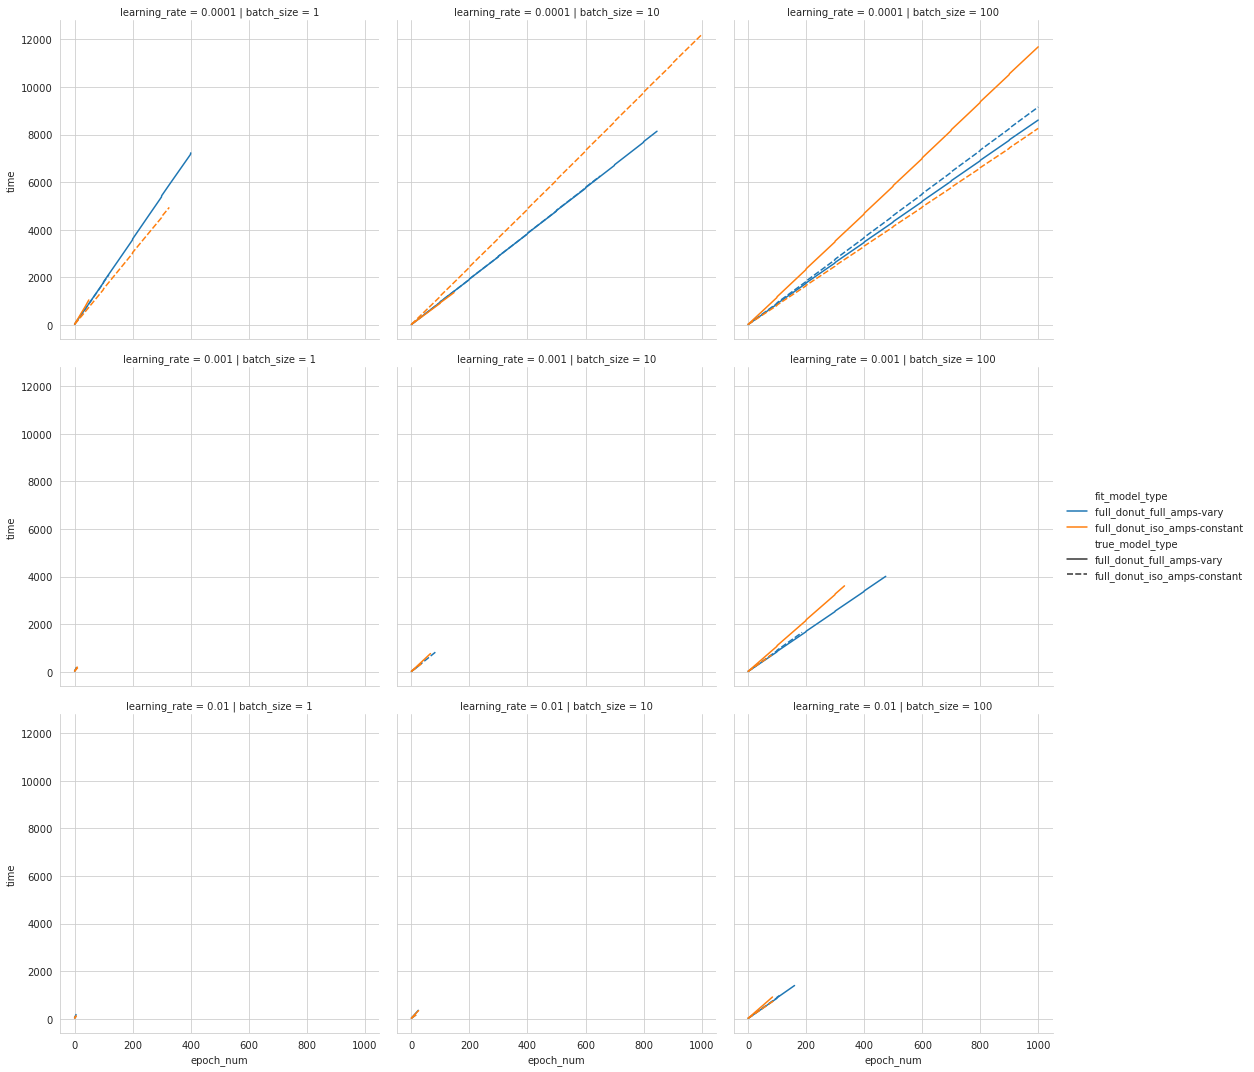

In [14]:
g=sns.relplot('epoch_num', 'time', 'fit_model_type', style='true_model_type', data=timing_df, col='batch_size', row='learning_rate', kind='line', legend='full')

Looking at the iteration-to-iteration changes in the loss, so when this is negative our performance is improving, and as it gets closer to zero, the optimization is converging.

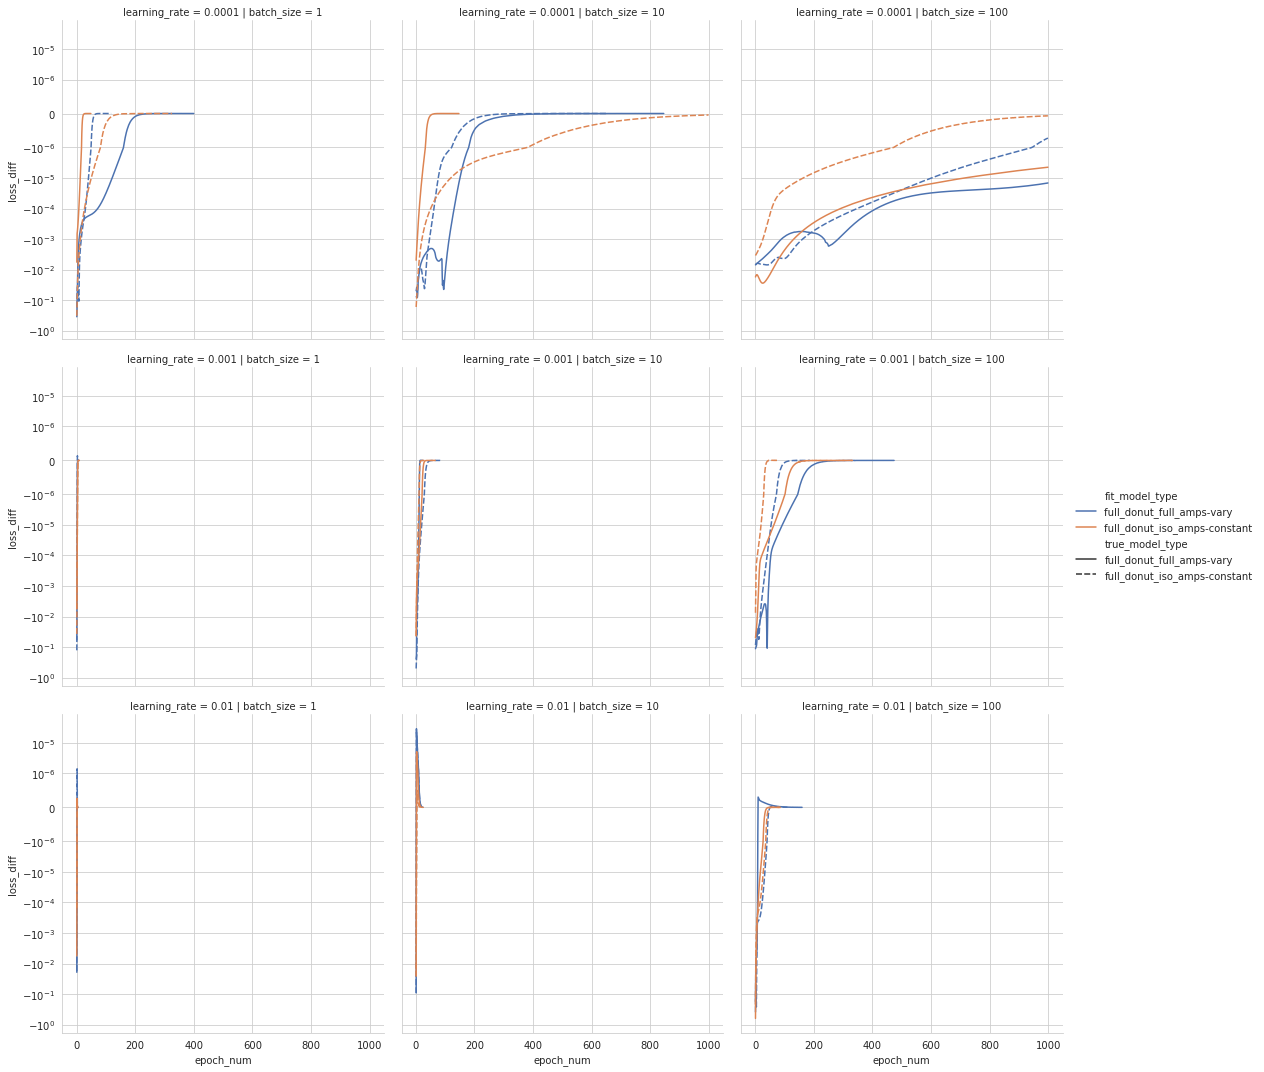

In [15]:
g = sns.relplot('epoch_num', 'loss_diff', 'fit_model_type', style='true_model_type', data=loss_df, col='batch_size', row='learning_rate', 
                kind='line', ci='sd', palette=sns.color_palette('deep', 2) )
                #facet_kws={'sharey':False, 'sharex': False})
for ax in g.axes.flatten():
    ax.set_yscale('symlog', basey=10, linthreshy=1e-6)

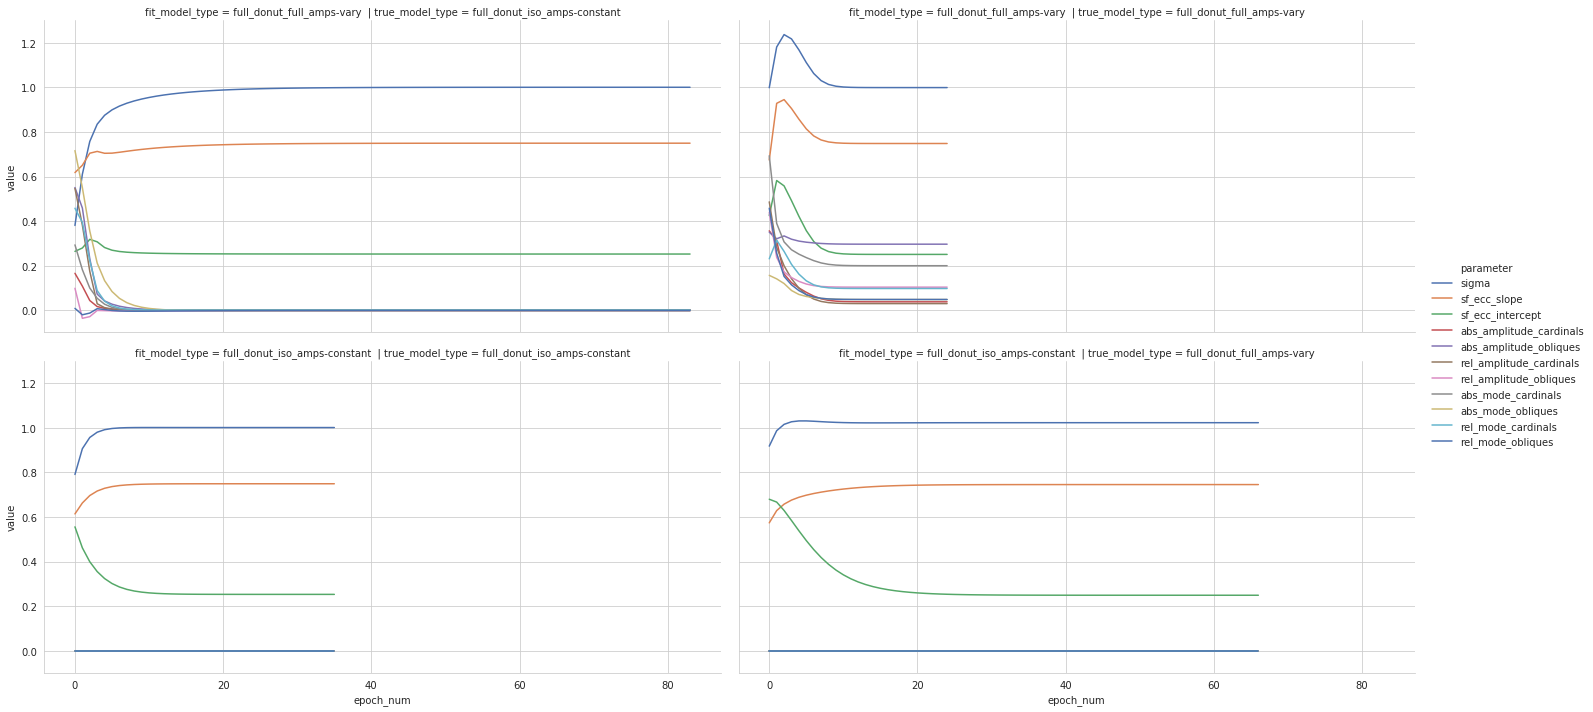

In [16]:
g=sns.relplot('epoch_num', 'value', 'parameter', row='fit_model_type', col='true_model_type', hue_order=sfp.plotting.PARAM_ORDER,# col='batch_size', row='learning_rate', 
              data=model_history.query("learning_rate==1e-3 & batch_size==10"), kind='line', aspect=2,
              ci='sd', palette=sns.color_palette('deep', 11))#facet_kws={'sharey': False})

This is really bad, looks like the model thinks we know nothing about anything. That is, the Hessian of each variable (which I was hoping to use as a measure of the uncertainty) is always exceedingly large (as can more easily be seen in the plots later on where we use the Hessian as error bars, the Hessian is approximately the same as the fit value of the parameter).

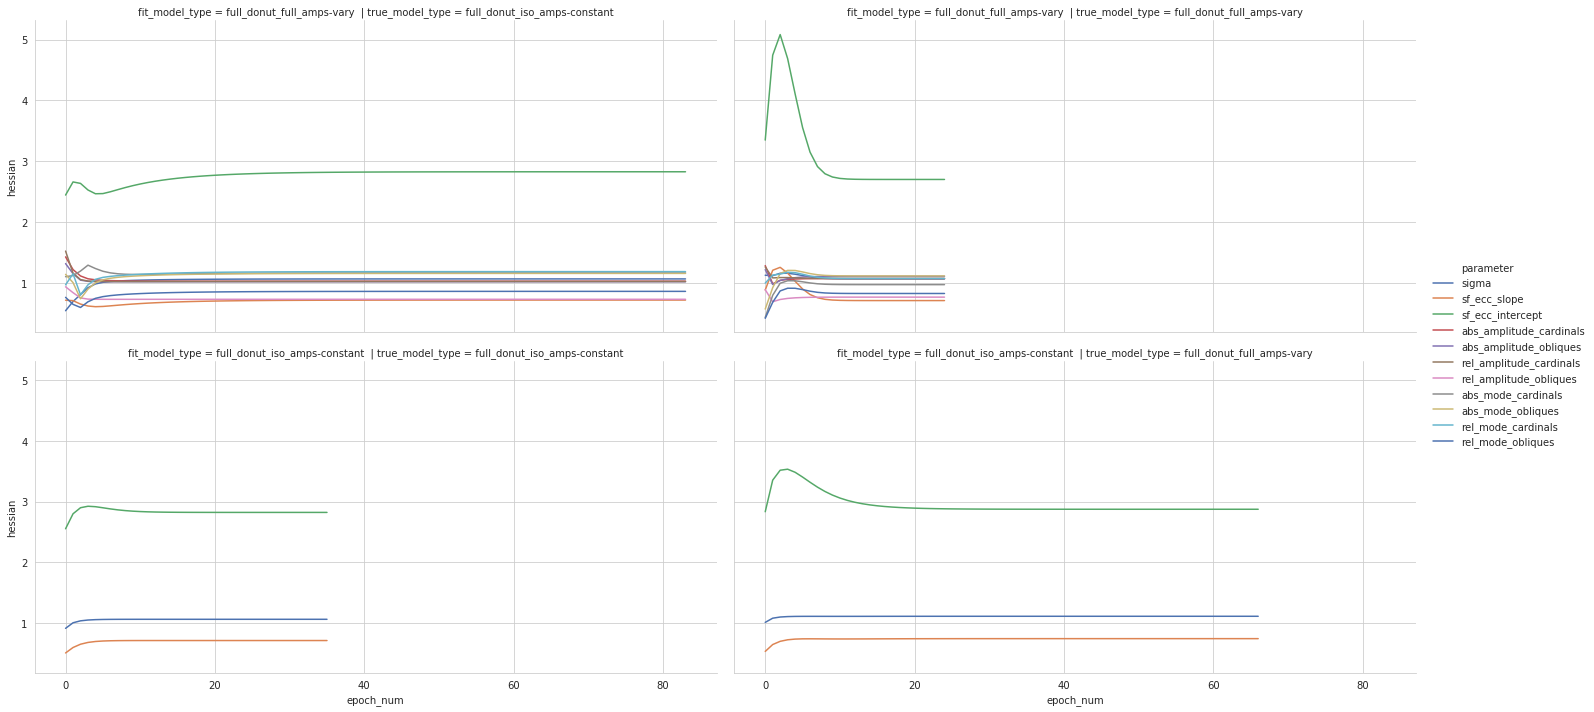

In [17]:
g=sns.relplot('epoch_num', 'hessian', 'parameter', row='fit_model_type', col='true_model_type', hue_order=sfp.plotting.PARAM_ORDER,# col='batch_size', row='learning_rate', 
              data=model_history.query("learning_rate==1e-3 & batch_size==10"), kind='line', aspect=2,
              ci='sd', palette=sns.color_palette('deep', 11))#facet_kws={'sharey': False})

Here we're plottig the iteration to iteration difference in the value of the parameter, so as this gets closer to zero, the optimization is getting closer to convergence.

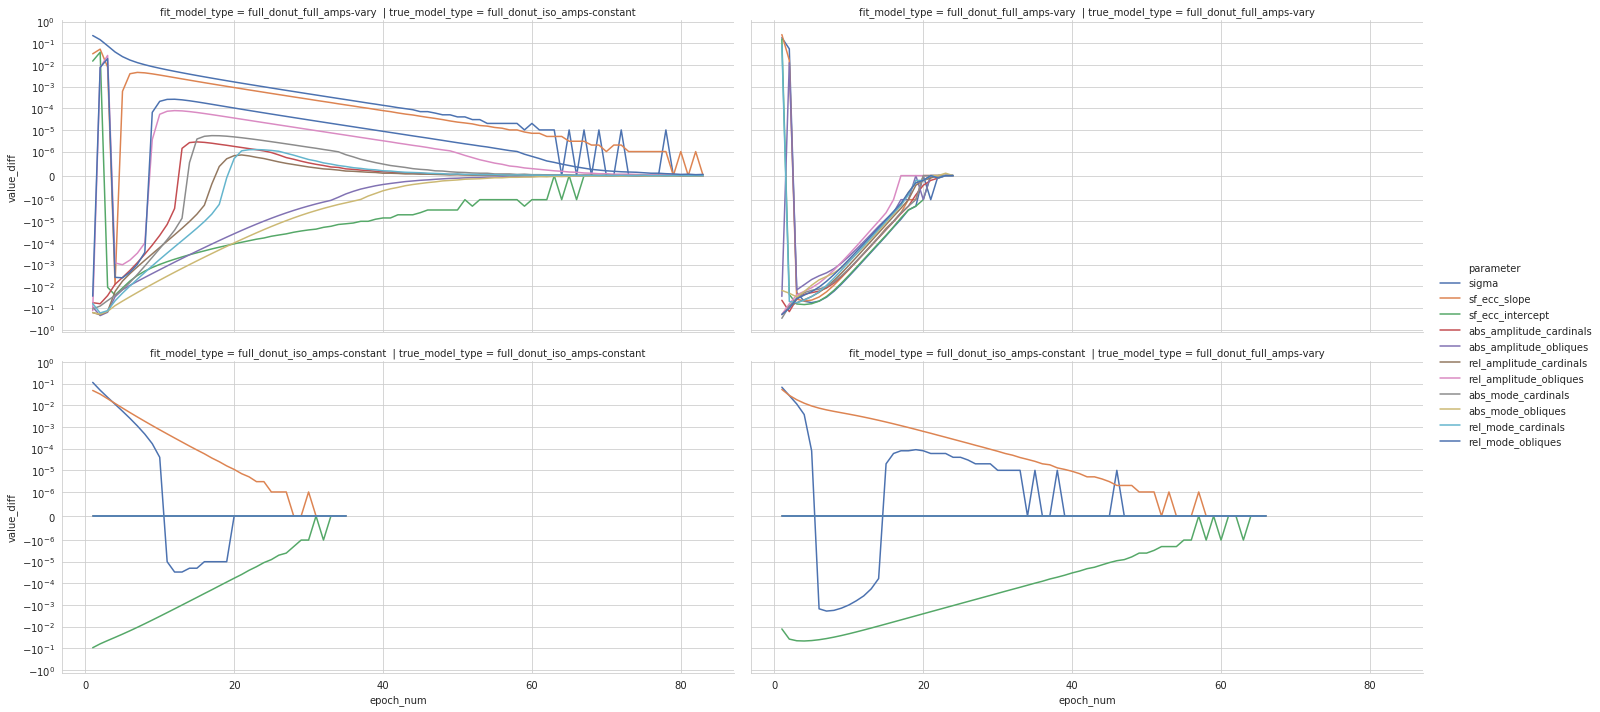

In [18]:
g=sns.relplot('epoch_num', 'value_diff', 'parameter', row='fit_model_type', col='true_model_type', hue_order=sfp.plotting.PARAM_ORDER,# col='batch_size', row='learning_rate', 
              data=model_history.query("learning_rate==1e-3 & batch_size==10"), kind='line', aspect=2,
              ci='sd', palette=sns.color_palette('deep', 11))#facet_kws={'sharey': False})
for ax in g.axes.flatten():
    ax.set_yscale('symlog', basey=10, linthreshy=1e-6)

Attempting to see the relationship between loss and number of iterations for batch size and learning rate.

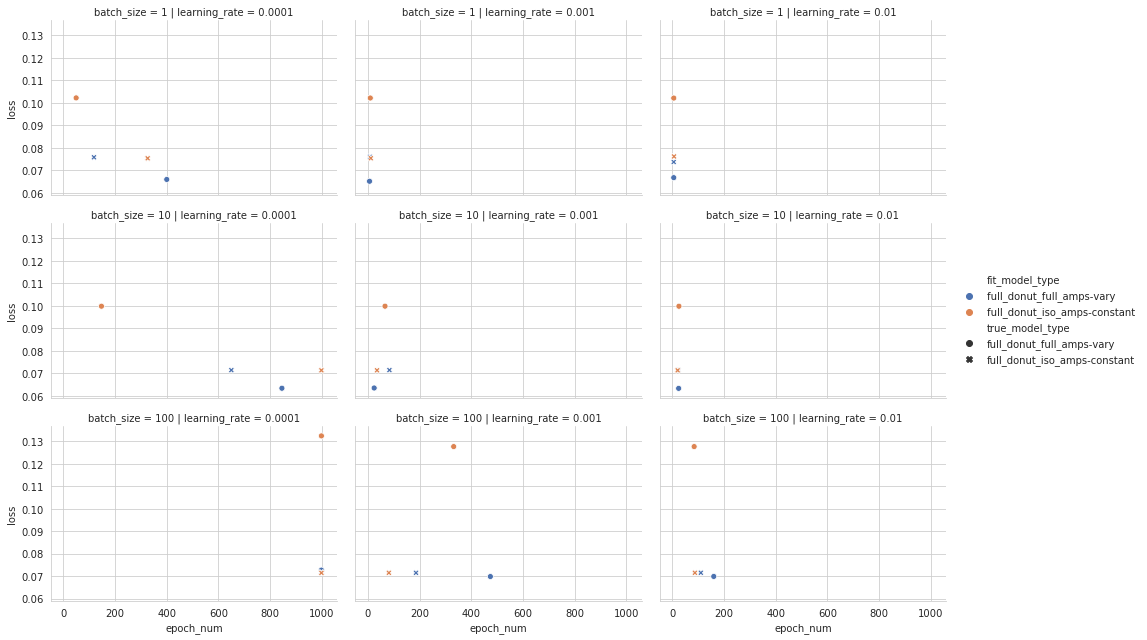

In [19]:
sns.relplot('epoch_num', 'loss', row='batch_size', col='learning_rate', data=avg_loss, hue='fit_model_type', style='true_model_type', legend='full', palette=sns.color_palette('deep', 2), aspect=1.5, height=3)

## Some simulated model recovery

Want to see if the `fit_model_type` with the lowest loss matches the `true_model_type` and whether we correctly recover the correct parameter values when the model has additional degrees of freedom (i.e., when it can fit parameters that are zero in the true model).

In [54]:
base_str = '/mnt/prince_scratch/spatial_frequency_preferences/derivatives/tuning_2d_simulated/noise-stim_class_bayesian_posterior_sub-wlsubj045_ses-04_task-sfprescaled_v1_e1-12/model_recovery/g0_all_'
models = pd.read_csv(base_str + 'models.csv')
model_history = pd.read_csv(base_str + 'model_history.csv')
timing_df = pd.read_csv(base_str + 'timing.csv')
avg_loss = pd.read_csv(base_str + 'loss.csv')
loss_df = pd.read_csv(base_str + 'diff.csv')

In [47]:
model_order = ['constant_donut_iso_amps-constant', 'scaling_donut_iso_amps-constant', 'full_donut_iso_amps-constant',
               'full_donut_absolute_amps-constant', 'full_donut_relative_amps-constant', 'full_donut_full_amps-constant',
               'full_donut_absolute_amps-vary', 'full_donut_relative_amps-vary', 'full_donut_full_amps-vary']

In [55]:
# hack to deal with this issue, hopefully fixed soon: https://github.com/mwaskom/seaborn/issues/1560
avg_loss.true_model_type = avg_loss.true_model_type.apply(lambda x: {'full_donut_full_amps-vary': 'full_donut_full_amps-vary ', 'full_donut_iso_amps-constant': 'full_donut_iso_amps-constant '}.get(x, x))
loss_df.true_model_type = loss_df.true_model_type.apply(lambda x: {'full_donut_full_amps-vary': 'full_donut_full_amps-vary ', 'full_donut_iso_amps-constant': 'full_donut_iso_amps-constant '}.get(x, x))
models.true_model_type = models.true_model_type.apply(lambda x: {'full_donut_full_amps-vary': 'full_donut_full_amps-vary ', 'full_donut_iso_amps-constant': 'full_donut_iso_amps-constant '}.get(x, x))
model_history.true_model_type = model_history.true_model_type.apply(lambda x: {'full_donut_full_amps-vary': 'full_donut_full_amps-vary ', 'full_donut_iso_amps-constant': 'full_donut_iso_amps-constant '}.get(x, x))
timing_df.true_model_type = timing_df.true_model_type.apply(lambda x: {'full_donut_full_amps-vary': 'full_donut_full_amps-vary ', 'full_donut_iso_amps-constant': 'full_donut_iso_amps-constant '}.get(x, x))

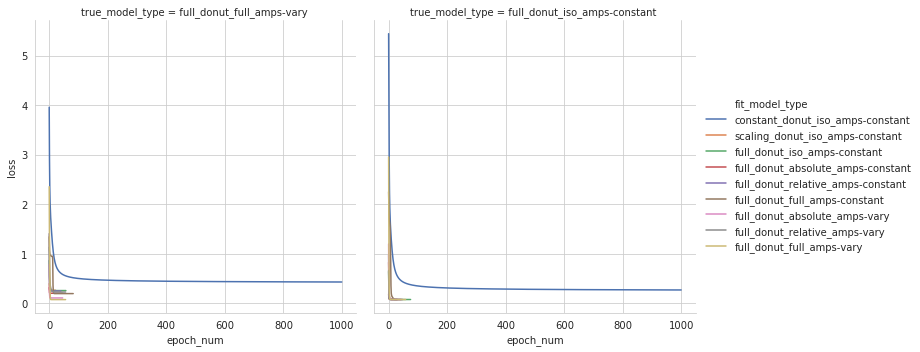

In [57]:
g = sns.relplot('epoch_num', 'loss', 'fit_model_type', col='true_model_type', data=loss_df, kind='line', ci='sd', palette=sns.color_palette('deep', 9), hue_order=model_order )
                #facet_kws={'sharey':False, 'sharex': False})
#g.set(ylim=(-.025, .05))

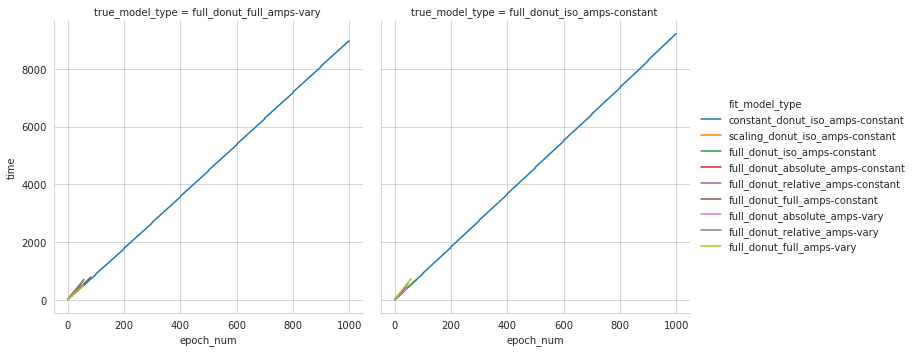

In [58]:
g=sns.relplot('epoch_num', 'time', 'fit_model_type', data=timing_df, col='true_model_type', kind='line', legend='full', hue_order=model_order)

Models that take longer and have highest loss are those that can't actually fit the data well -- that is, they have too few parameters. Models with too many parameters tend to do okay and reach a reasonably low loss

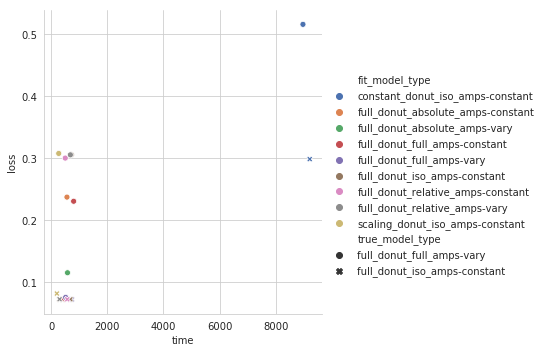

In [59]:
sns.relplot('time', 'loss', 'fit_model_type', data=avg_loss, style='true_model_type', legend='full', palette=sns.color_palette('deep', 9), )#hue_order=[i+" " for i in model_order])

In [60]:
models.pivot_table('fit_value', ['true_model_type', 'fit_model_type'], 'model_parameter')

model_parameter                                                  abs_amplitude_cardinals  \
true_model_type               fit_model_type                                               
full_donut_full_amps-vary     constant_donut_iso_amps-constant                  0.000000   
                              full_donut_absolute_amps-constant                 0.000000   
                              full_donut_absolute_amps-vary                     0.042022   
                              full_donut_full_amps-constant                     0.000000   
                              full_donut_full_amps-vary                         0.042725   
                              full_donut_iso_amps-constant                      0.000000   
                              full_donut_relative_amps-constant                 0.000000   
                              full_donut_relative_amps-vary                     0.000000   
                              scaling_donut_iso_amps-constant                   0.000000   
full_donut_iso_amps-constant  constant_donut_iso_amps-constant                  0.000000   
                              full_donut_absolute_amps-constant                 0.000000   
                              full_donut_absolute_amps-vary                     0.001197   
                              full_donut_full_amps-constant                     0.000000   
                              full_donut_full_amps-vary                         0.000700   
                              full_donut_iso_amps-constant                      0.000000   
                              full_donut_relative_amps-constant                 0.000000   
                              full_donut_relative_amps-vary                     0.000000   
                              scaling_donut_iso_amps-constant                   0.000000   

model_parameter                                                  abs_amplitude_obliques  \
true_model_type               fit_model_type                                              
full_donut_full_amps-vary     constant_donut_iso_amps-constant                 0.000000   
                              full_donut_absolute_amps-constant                0.000000   
                              full_donut_absolute_amps-vary                    0.287259   
                              full_donut_full_amps-constant                    0.000000   
                              full_donut_full_amps-vary                        0.299020   
                              full_donut_iso_amps-constant                     0.000000   
                              full_donut_relative_amps-constant                0.000000   
                              full_donut_relative_amps-vary                    0.000000   
                              scaling_donut_iso_amps-constant                  0.000000   
full_donut_iso_amps-constant  constant_donut_iso_amps-constant                 0.000000   
                              full_donut_absolute_amps-constant                0.000000   
                              full_donut_absolute_amps-vary                    0.000379   
                              full_donut_full_amps-constant                    0.000000   
                              full_donut_full_amps-vary                        0.000678   
                              full_donut_iso_amps-constant                     0.000000   
                              full_donut_relative_amps-constant                0.000000   
                              full_donut_relative_amps-vary                    0.000000   
                              scaling_donut_iso_amps-constant                  0.000000   

model_parameter                                                  abs_mode_cardinals  \
true_model_type               fit_model_type                                          
full_donut_full_amps-vary     constant_donut_iso_amps-constant             0.000000   
                              full_donut_absolute_amps-constant            0.

In [61]:
models.pivot_table('true_value', ['true_model_type'], 'model_parameter')

model_parameter,abs_amplitude_cardinals,abs_amplitude_obliques,abs_mode_cardinals,abs_mode_obliques,rel_amplitude_cardinals,rel_amplitude_obliques,rel_mode_cardinals,rel_mode_obliques,sf_ecc_intercept,sf_ecc_slope,sigma
true_model_type,,,,,,,,,,,
full_donut_full_amps-vary,0.04,0.3,0.2,0.05,0.03,0.1,0.1,0.05,0.25,0.75,1.0
full_donut_iso_amps-constant,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.25,0.75,1.0


Comparing the fit parameter values with the actual ones (dashed black line) for `true_model_type=="full_donut_full_amps-vary"`, using Hessianss as error bars. We see error bars are real big and generally don't differ among different fit models (with the exception of `sf_ecc_intercept`), so we're not going to end up using them.

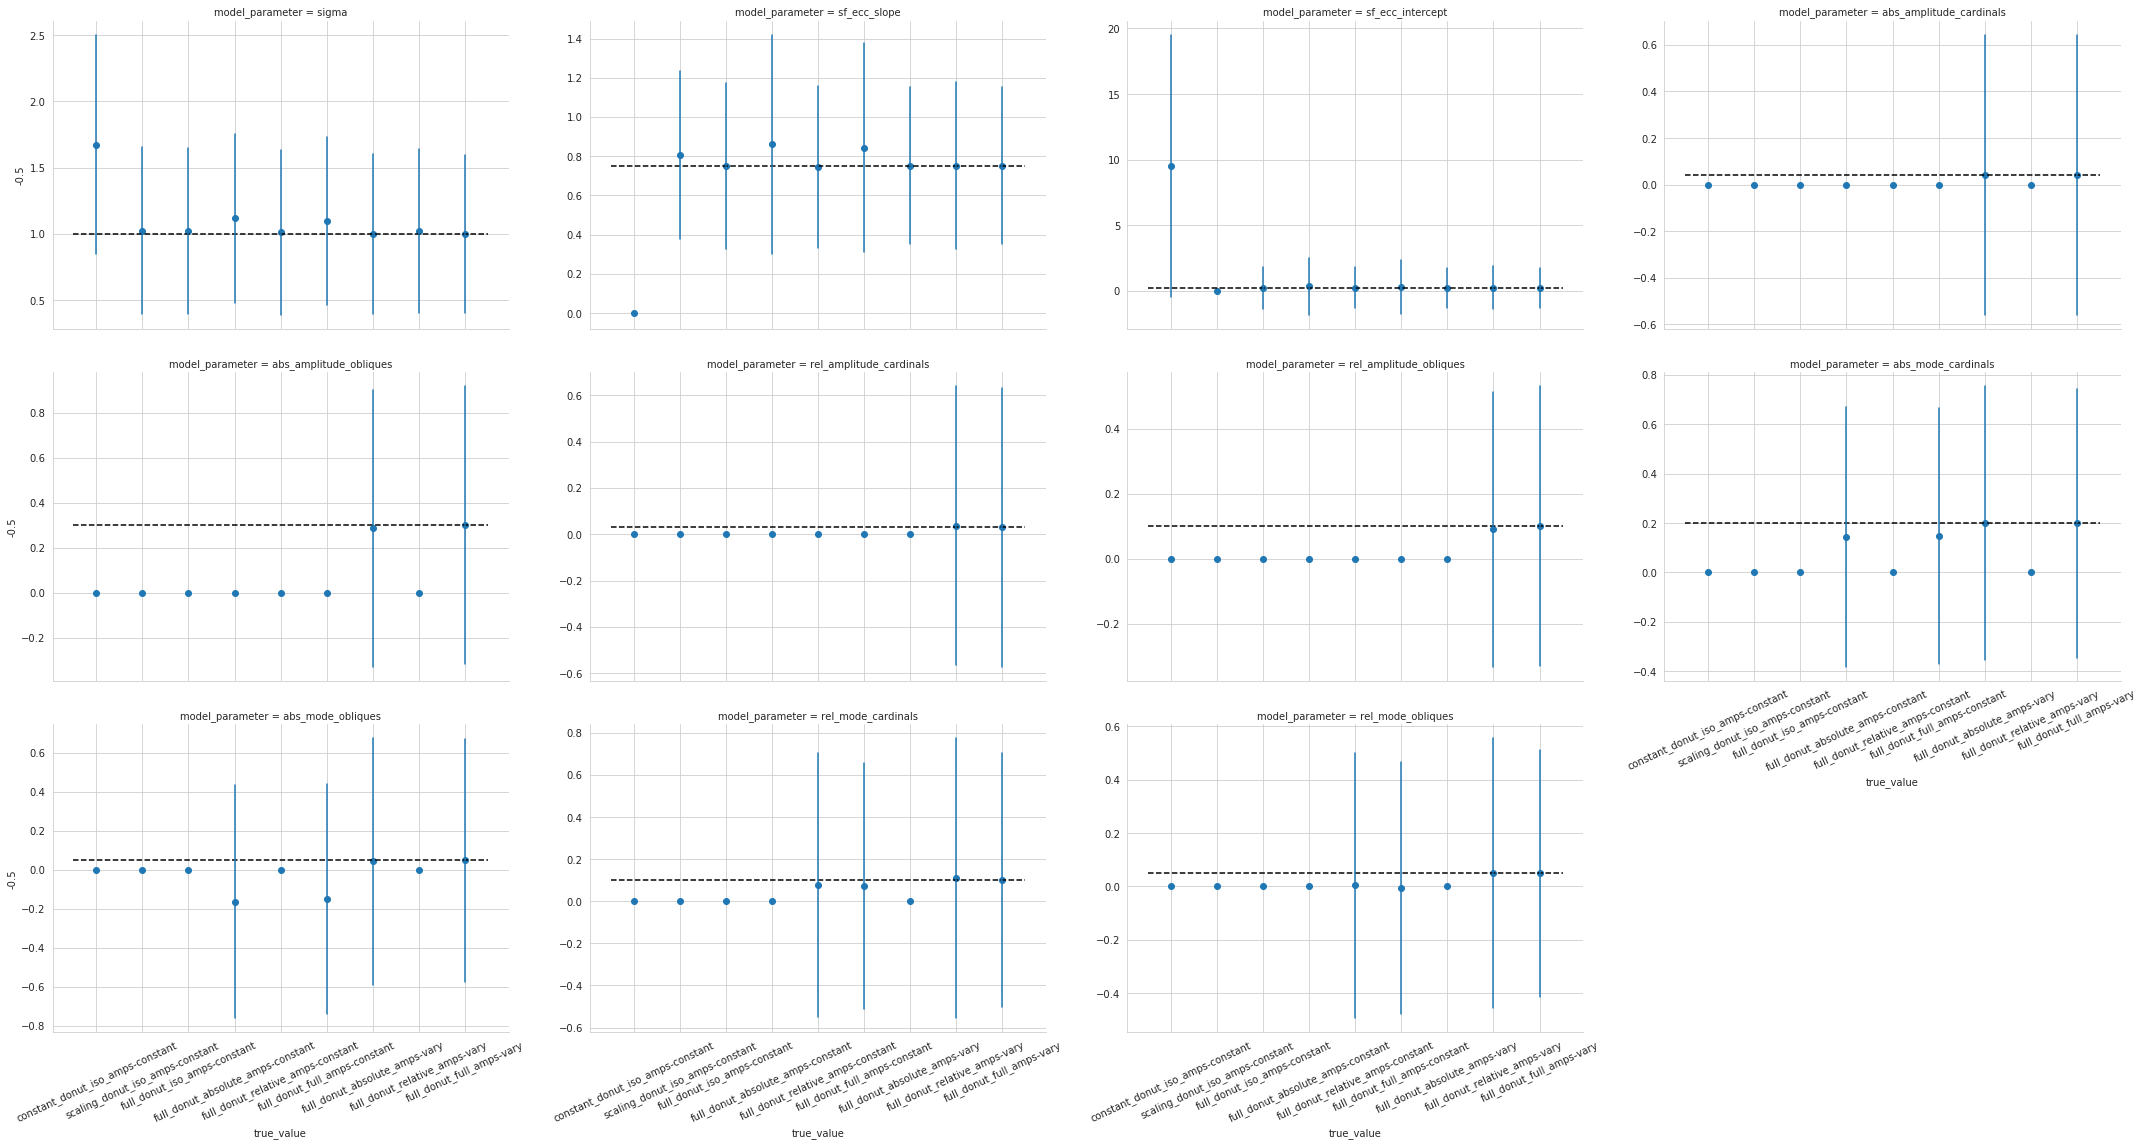

In [63]:
param_col_order = ['sigma', 'sf_ecc_slope', 'sf_ecc_intercept']
param_col_order.extend(['%s_%s_%s' % (i, j ,k) for j, i, k in itertools.product(['amplitude', 'mode'], ['abs', 'rel'], ['cardinals', 'obliques'])])

def custom_hline(y, xmin, xmax, **kwargs):
    data = kwargs.pop('data')
    kwargs.pop('color')
    if data[y].nunique() > 1:
        warnings.warn("No unique value for %s, so can't plot!" % y)
    else:
        plt.hlines(data[y].unique()[0], xmin, xmax, **kwargs)

g = sns.FacetGrid(data=models.query('true_model_type=="full_donut_full_amps-vary "'), col='model_parameter',
                  palette=sns.color_palette('deep', 9), col_wrap=4, col_order=param_col_order, height=5, aspect=1.5, sharey=False)
g.map_dataframe(sfp.plotting.scatter_ci_col, 'fit_model_type', 'fit_value', 'hessian', x_order=model_order)
g.map_dataframe(custom_hline, 'true_value', -.5, 8.5, linestyles='dashed')
for ax in g.axes.flatten():
    labels = ax.get_xticklabels()
    if labels:
        ax.set_xticklabels(labels, rotation=25)

Comparing the fit parameter values with the actual ones (dashed black line) for `true_model_type=="full_donut_iso_amps-constant"`, using Hessianss as error bars. We see error bars are real big and generally don't differ among different fit models (with the exception of `sf_ecc_intercept`), so we're not going to end up using them.

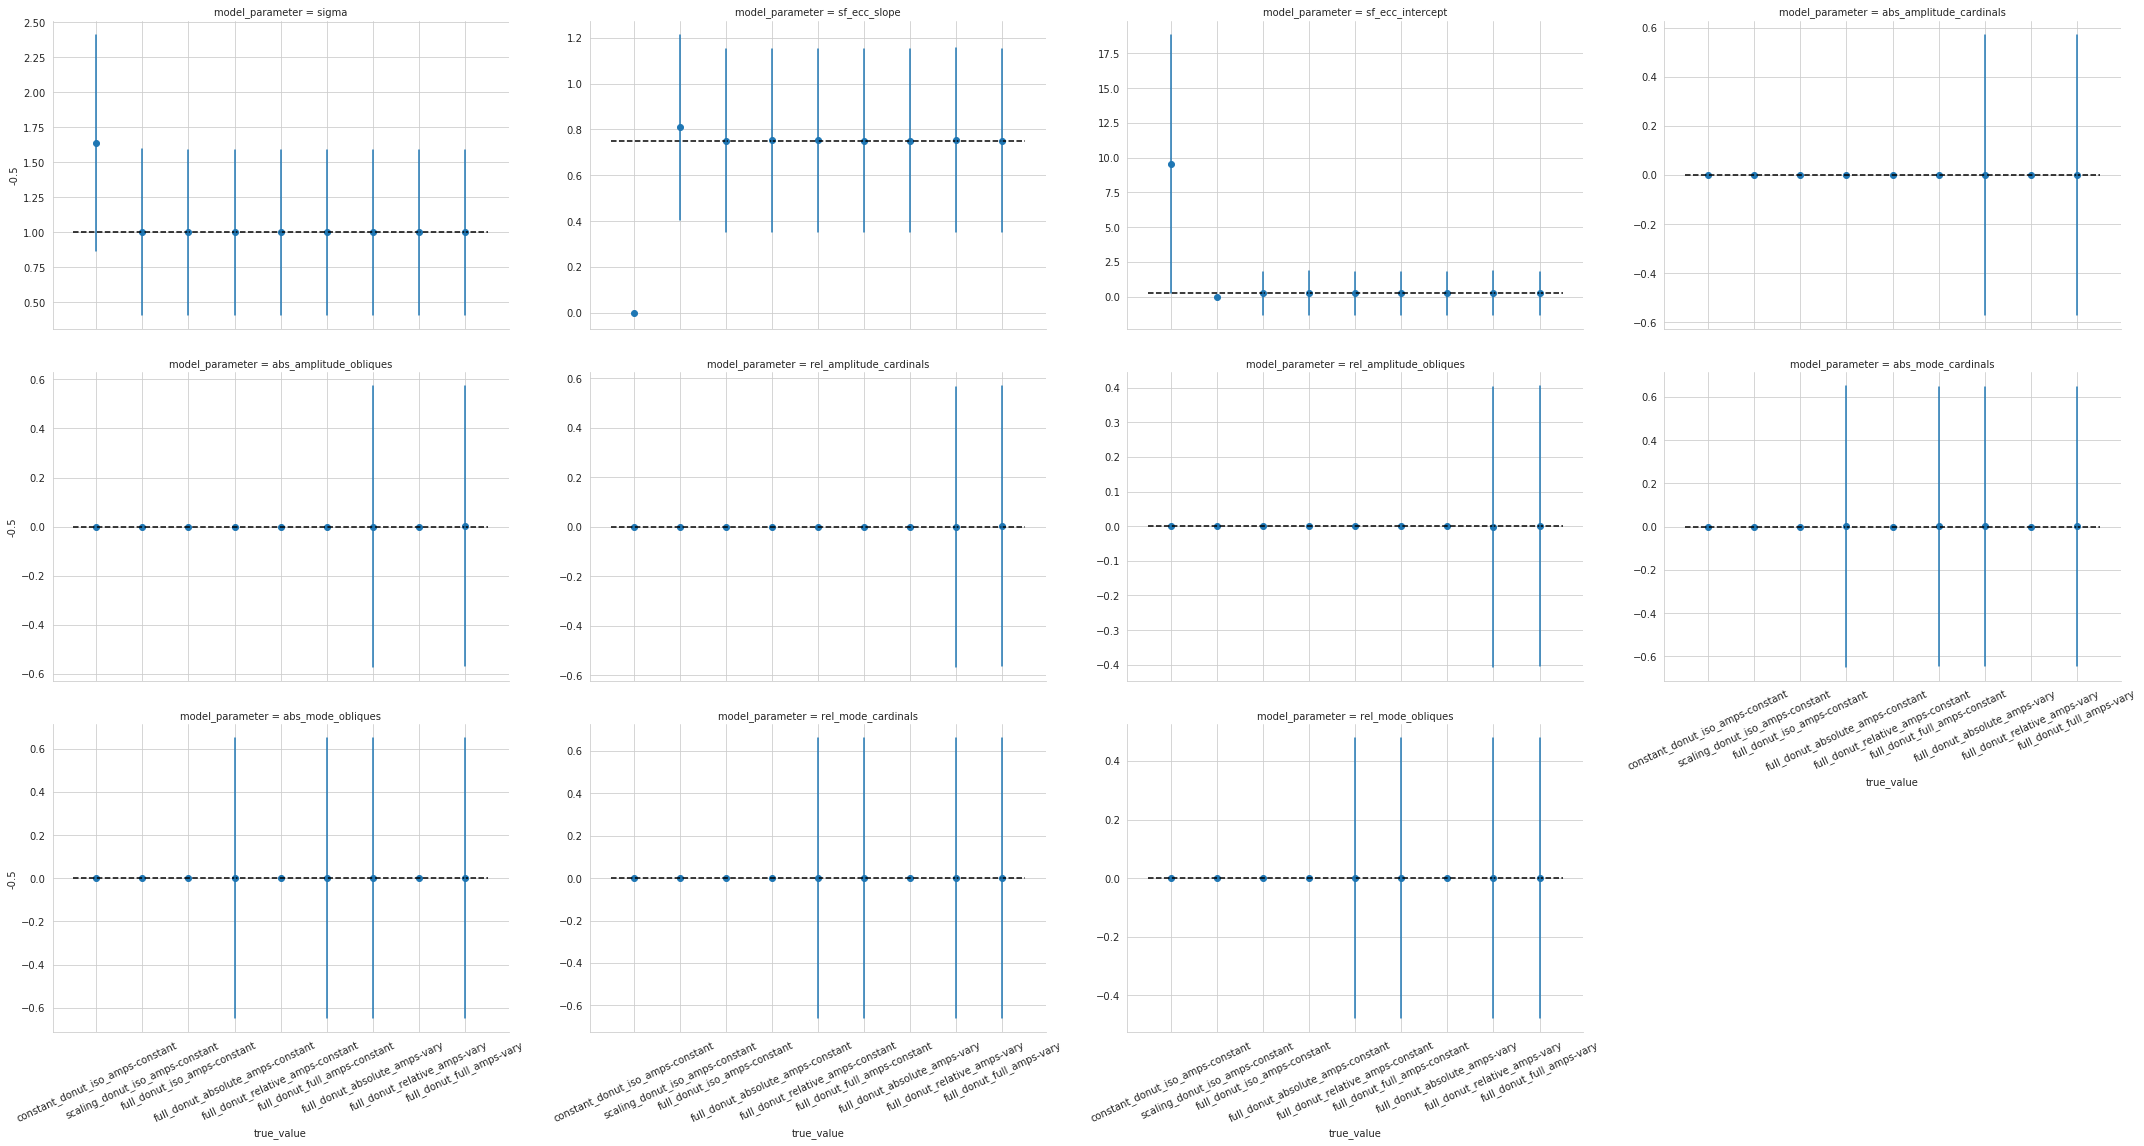

In [64]:
param_col_order = ['sigma', 'sf_ecc_slope', 'sf_ecc_intercept']
param_col_order.extend(['%s_%s_%s' % (i, j ,k) for j, i, k in itertools.product(['amplitude', 'mode'], ['abs', 'rel'], ['cardinals', 'obliques'])])

def custom_hline(y, xmin, xmax, **kwargs):
    data = kwargs.pop('data')
    kwargs.pop('color')
    if data[y].nunique() > 1:
        warnings.warn("No unique value for %s, so can't plot!" % y)
    else:
        plt.hlines(data[y].unique()[0], xmin, xmax, **kwargs)

g = sns.FacetGrid(data=models.query('true_model_type=="full_donut_iso_amps-constant "'), col='model_parameter',
                  palette=sns.color_palette('deep', 9), col_wrap=4, col_order=param_col_order, height=5, aspect=1.5, sharey=False)
g.map_dataframe(sfp.plotting.scatter_ci_col, 'fit_model_type', 'fit_value', 'hessian', x_order=model_order)
g.map_dataframe(custom_hline, 'true_value', -.5, 8.5, linestyles='dashed')
for ax in g.axes.flatten():
    labels = ax.get_xticklabels()
    if labels:
        ax.set_xticklabels(labels, rotation=25)

## Some simulated cross-validated model recovery

The above shows that the correct model will have the lowest loss (or among the lowest loss) and we won't overfit, with the major assumption that the true model is one of the ones we're fitting (i.e., there's no modeling errors). This is an assumption we want to avoid. Can't really effectively run a simulation of the real-world case, because if we could come up with interesting phenomena in the data, we would model them. So here we just make sure that cross-validation is well-behaved if there's no modeling errors.

The way we actually want to perform model selection is using cross-validation, so we want to make sure that the correct model has the best cross-validated loss. When a model is over-parameterized, it could also have a pretty good cross-validated loss, assuming it correctly sets the unnecessary parameters to 0.



In [4]:
base_str = '/users/broderick/mnt/prince_scratch/spatial_frequency_preferences/derivatives/tuning_2d_simulated/noise-stim_class_bayesian_posterior_sub-wlsubj045_ses-04_task-sfprescaled_v1_e1-12/model_recovery_cv/b10_r.001_g0_s0_all_'
models = pd.read_csv(base_str + 'models.csv')
timing_df = pd.read_csv(base_str + 'timing.csv')
avg_loss = pd.read_csv(base_str + 'loss.csv')
cv_loss = pd.read_csv(base_str + 'cv_loss.csv')

In [5]:
model_order = ['constant_donut_iso_amps-constant', 'scaling_donut_iso_amps-constant', 'full_donut_iso_amps-constant',
               'full_donut_absolute_amps-constant', 'full_donut_relative_amps-constant', 'full_donut_full_amps-constant',
               'full_donut_absolute_amps-vary', 'full_donut_relative_amps-vary', 'full_donut_full_amps-vary']

In [6]:
# hack to deal with this issue, hopefully fixed soon: https://github.com/mwaskom/seaborn/issues/1560
avg_loss.true_model_type = avg_loss.true_model_type.apply(lambda x: {'full_donut_full_amps-vary': 'full_donut_full_amps-vary ', 'full_donut_iso_amps-constant': 'full_donut_iso_amps-constant '}.get(x, x))
cv_loss.true_model_type = cv_loss.true_model_type.apply(lambda x: {'full_donut_full_amps-vary': 'full_donut_full_amps-vary ', 'full_donut_iso_amps-constant': 'full_donut_iso_amps-constant '}.get(x, x))
models.true_model_type = models.true_model_type.apply(lambda x: {'full_donut_full_amps-vary': 'full_donut_full_amps-vary ', 'full_donut_iso_amps-constant': 'full_donut_iso_amps-constant '}.get(x, x))
timing_df.true_model_type = timing_df.true_model_type.apply(lambda x: {'full_donut_full_amps-vary': 'full_donut_full_amps-vary ', 'full_donut_iso_amps-constant': 'full_donut_iso_amps-constant '}.get(x, x))

Fortunately, correct model has lowest cross-validated loss, though over-parameterized models can get basically the same value -- this is because, as we'll see in further plots, they're correctly setting the unnecessary parameters to0.

In [16]:
pd.pivot_table(cv_loss, 'cv_loss', ['true_model_type', 'fit_model_type'], ).sort_values(['true_model_type','cv_loss'])#.reindex(itertools.product(['full_donut_full_amps-vary', 'full_donut_iso_amps-constant'], model_order),)

cv_loss
true_model_type               fit_model_type                             
full_donut_full_amps-vary     full_donut_full_amps-vary          0.076134
                              full_donut_relative_amps-vary      0.118201
                              full_donut_absolute_amps-vary      0.118805
                              full_donut_absolute_amps-constant  0.120931
                              full_donut_iso_amps-constant       0.159378
                              scaling_donut_iso_amps-constant    0.164462
                              constant_donut_iso_amps-constant   0.342039
                              full_donut_full_amps-constant      0.400195
                              full_donut_relative_amps-constant  0.759471
full_donut_iso_amps-constant  full_donut_iso_amps-constant       0.075958
                              full_donut_absolute_amps-constant  0.075965
                              full_donut_absolute_amps-vary      0.075966
                              full_donut_full_amps-vary          0.075972
                              scaling_donut_iso_amps-constant    0.081527
                              full_donut_full_amps-constant      0.164600
                              full_donut_relative_amps-vary      0.201027
                              constant_donut_iso_amps-constant   0.270249
                              full_donut_relative_amps-constant  0.333873

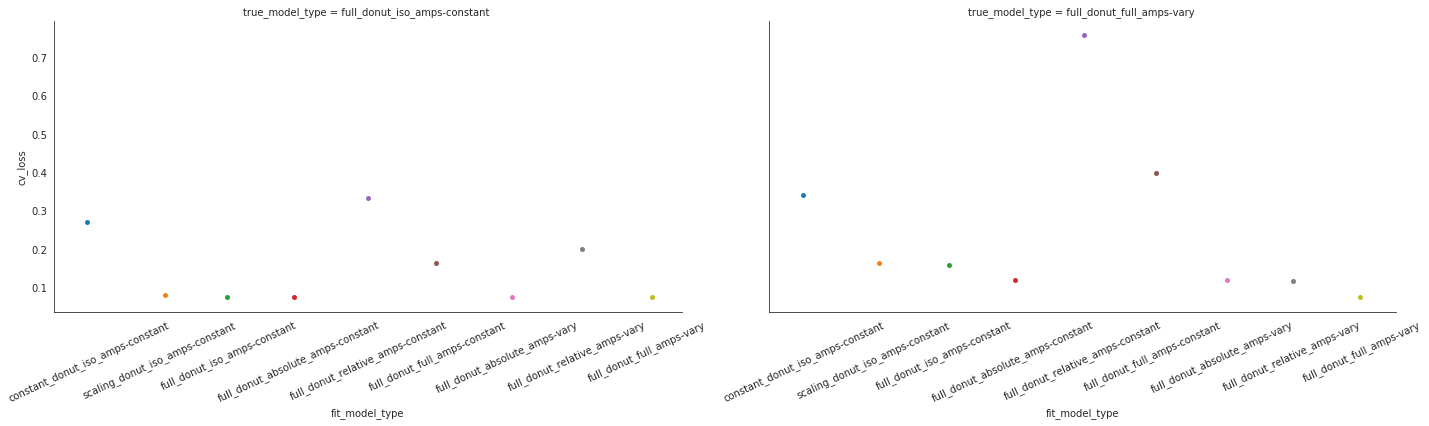

In [22]:
g = sns.catplot('fit_model_type', 'cv_loss', data=cv_loss, col='true_model_type', order=model_order, aspect=2)
for ax in g.axes.flatten():
    labels = ax.get_xticklabels()
    if labels:
        ax.set_xticklabels(labels, rotation=25)

These plots use the hessian to show the error bars, but I think they're unreasonably large -- in the actual analysis, we'll use bootstraps.

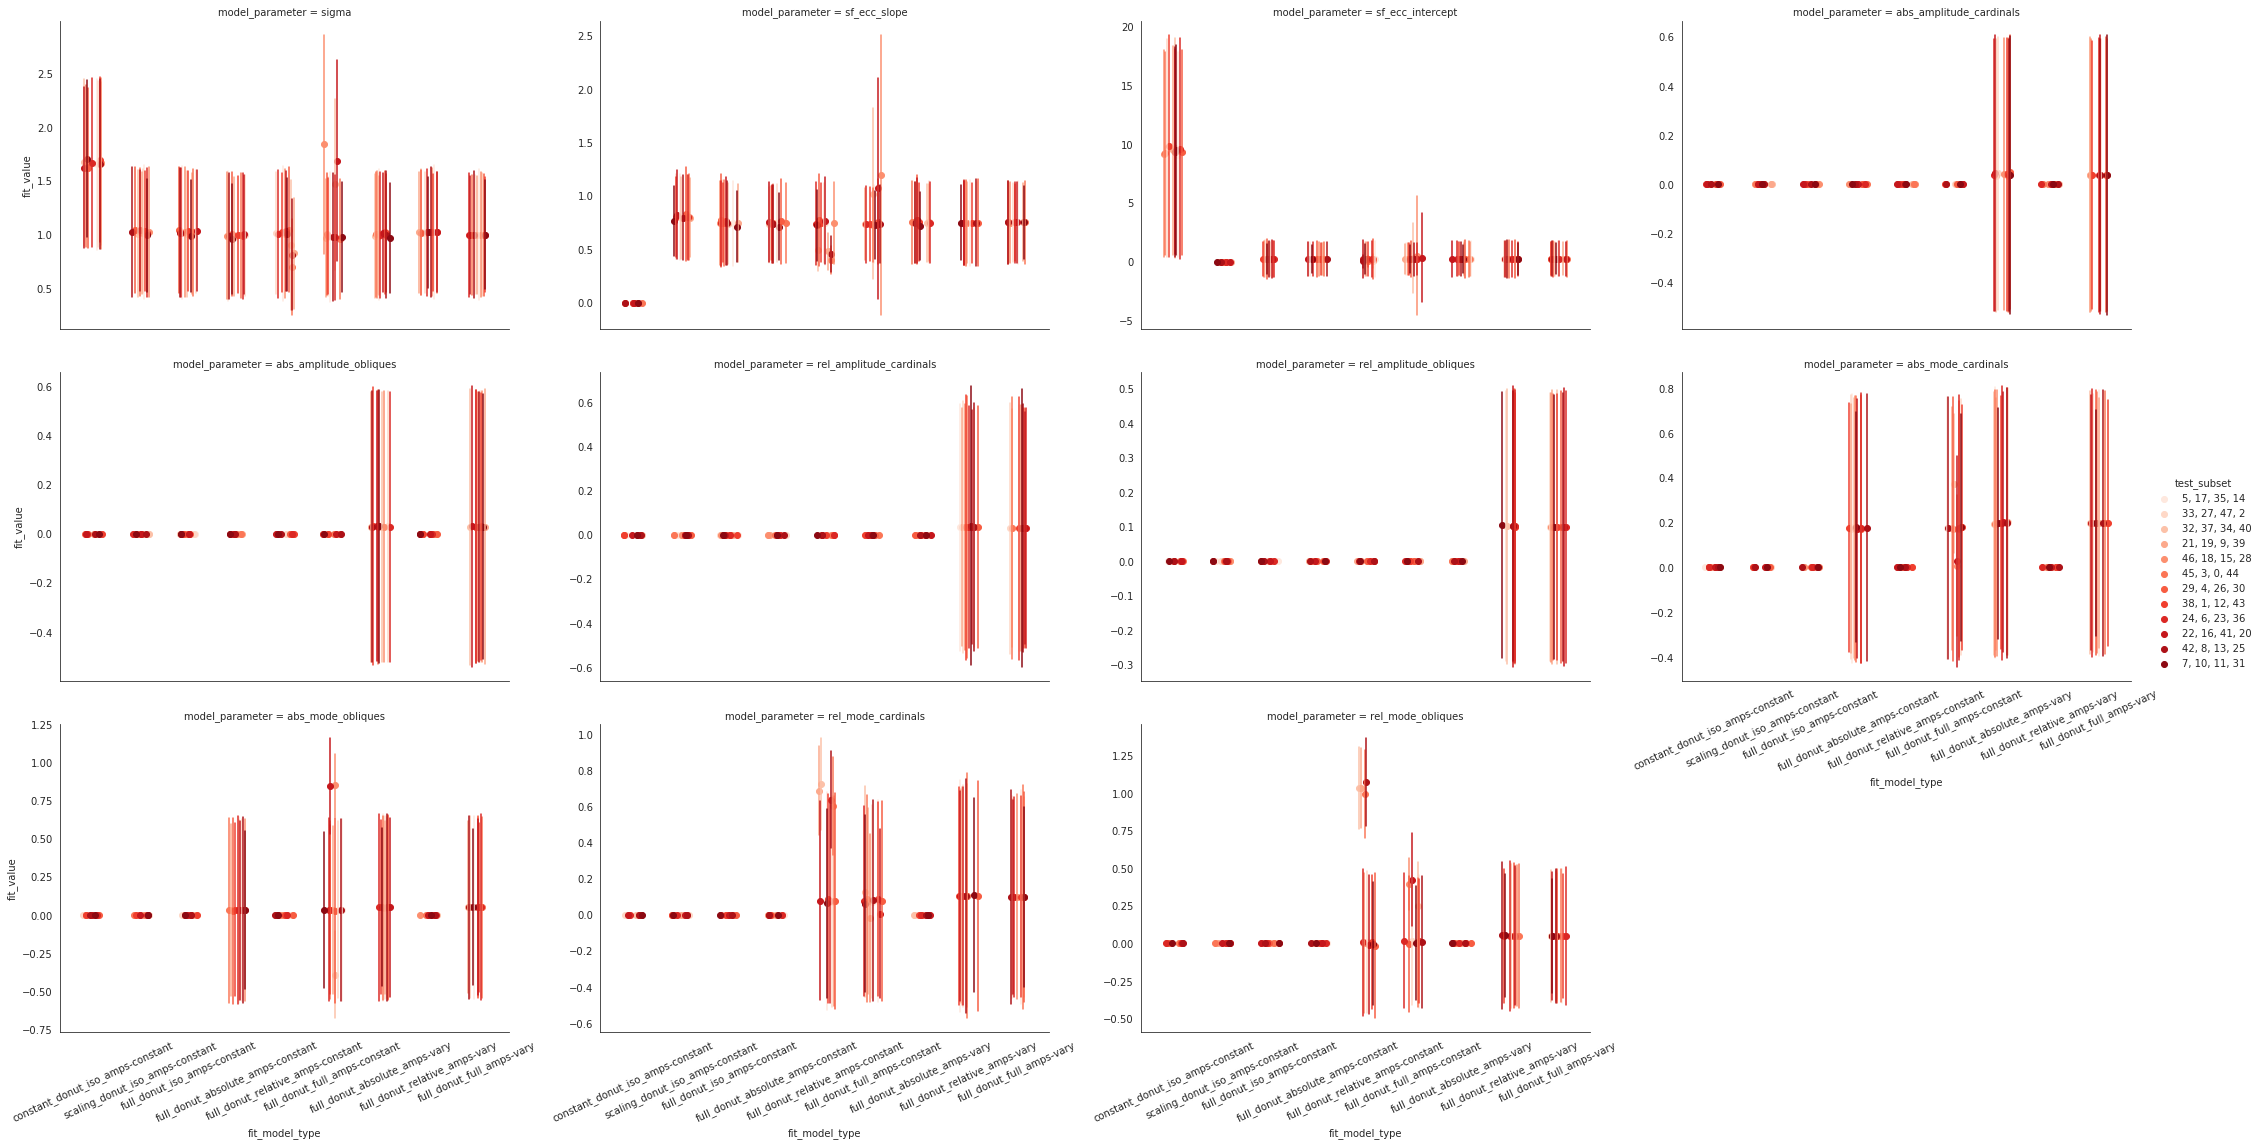

In [27]:
param_col_order = ['sigma', 'sf_ecc_slope', 'sf_ecc_intercept']
param_col_order.extend(['%s_%s_%s' % (i, j ,k) for j, i, k in itertools.product(['amplitude', 'mode'], ['abs', 'rel'], ['cardinals', 'obliques'])])

def custom_hline(y, xmin, xmax, **kwargs):
    data = kwargs.pop('data')
    kwargs.pop('color')
    if data[y].nunique() > 1:
        warnings.warn("No unique value for %s, so can't plot!" % y)
    else:
        plt.hlines(data[y].unique()[0], xmin, xmax, **kwargs)

g = sns.FacetGrid(data=models.query('true_model_type=="full_donut_full_amps-vary "'), col='model_parameter', hue='test_subset',
                  palette=sns.color_palette('Reds', 12), col_wrap=4, col_order=param_col_order, height=5, aspect=1.5, sharey=False)
g.map_dataframe(sfp.plotting.scatter_ci_col, 'fit_model_type', 'fit_value', 'hessian', x_order=model_order, x_jitter=.2)
# g.map_dataframe(custom_hline, 'true_value', -.5, 8.5, linestyles='dashed')
for ax in g.axes.flatten():
    labels = ax.get_xticklabels()
    if labels:
        ax.set_xticklabels(labels, rotation=25)
g.add_legend()

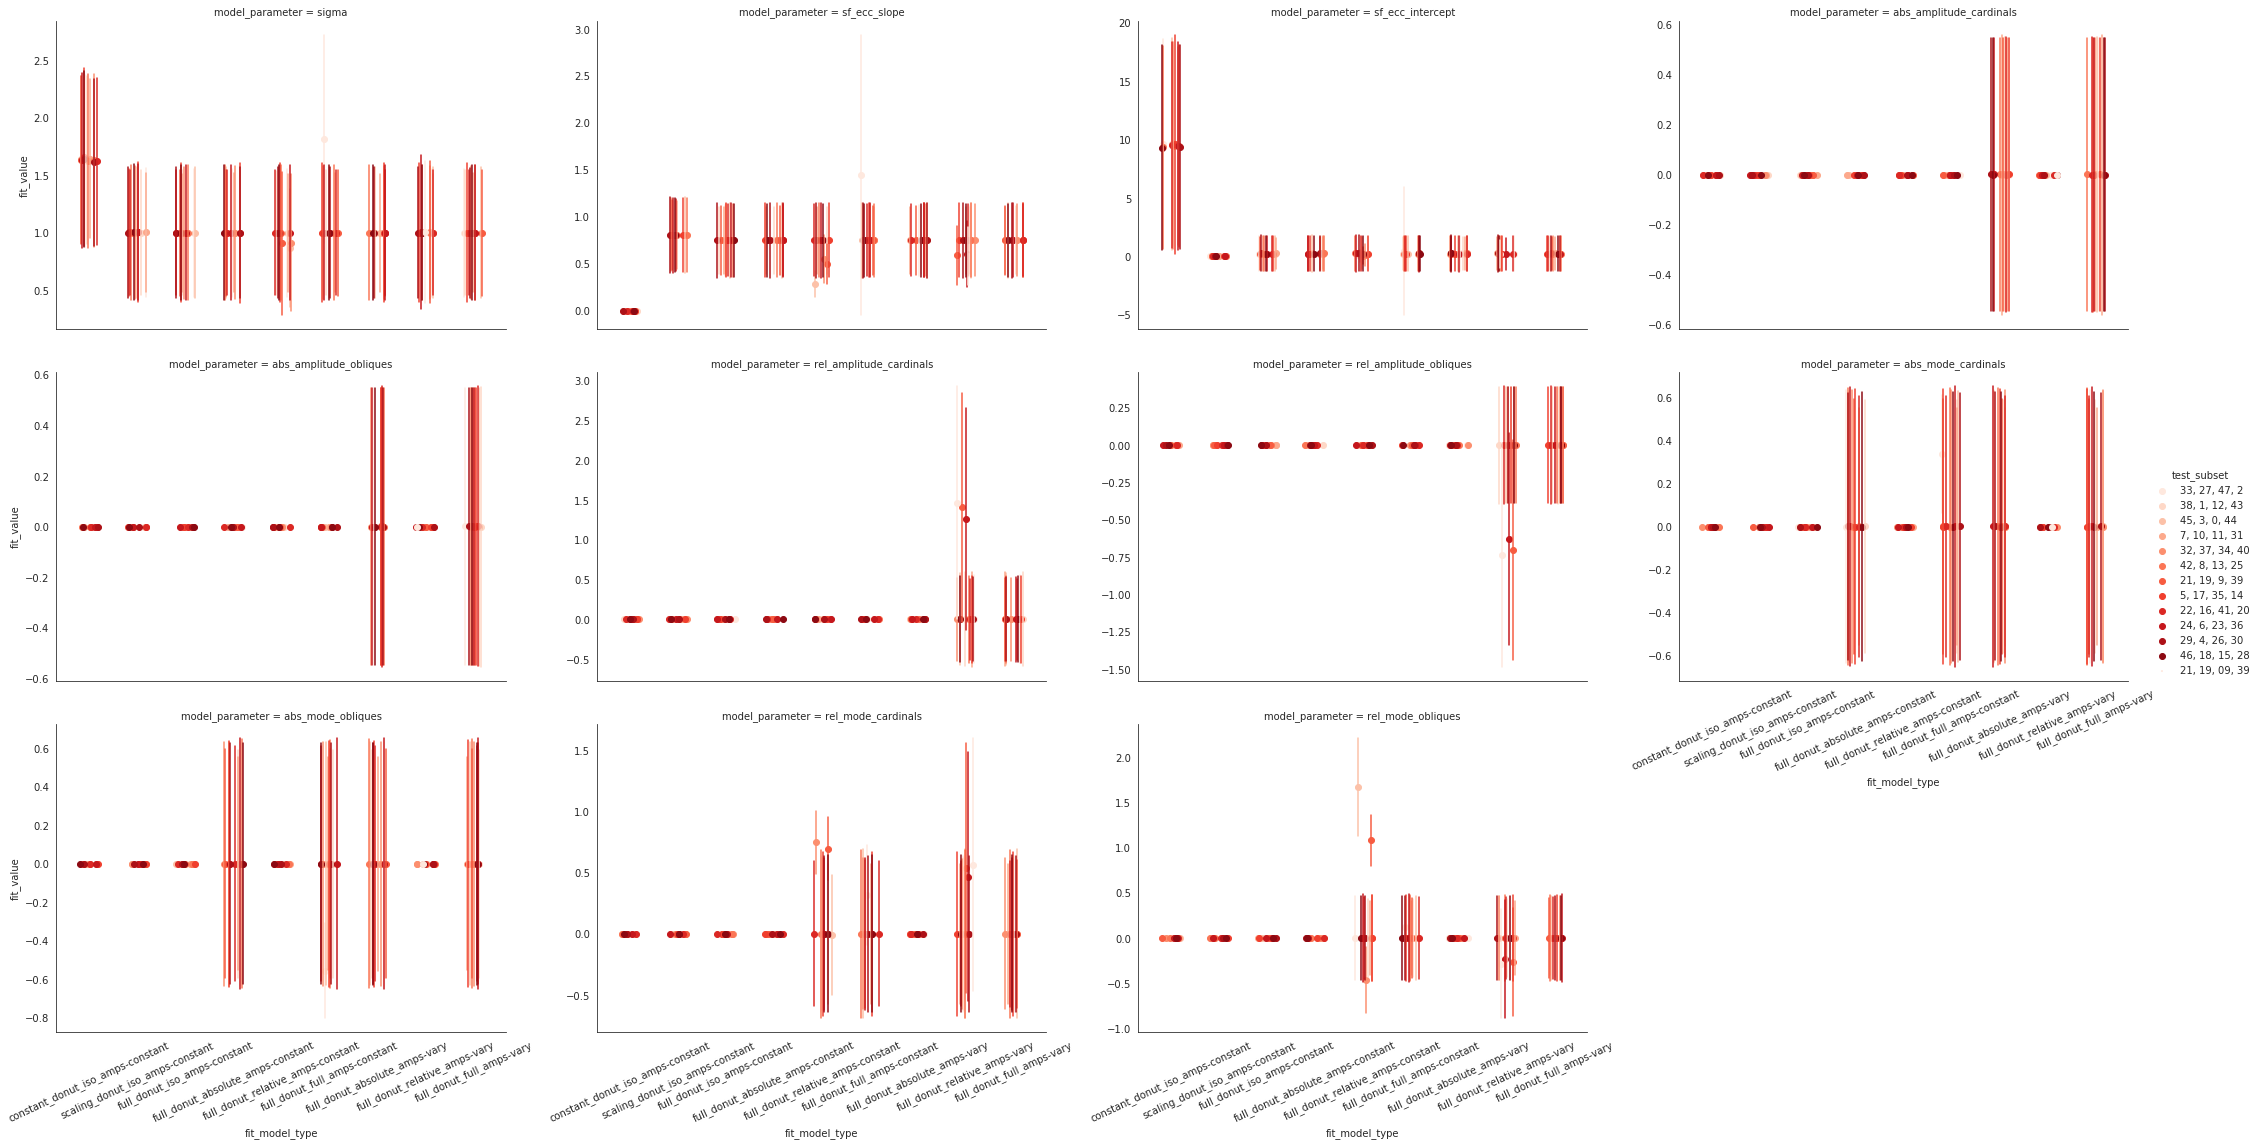

In [34]:
param_col_order = ['sigma', 'sf_ecc_slope', 'sf_ecc_intercept']
param_col_order.extend(['%s_%s_%s' % (i, j ,k) for j, i, k in itertools.product(['amplitude', 'mode'], ['abs', 'rel'], ['cardinals', 'obliques'])])

def custom_hline(y, xmin, xmax, **kwargs):
    data = kwargs.pop('data')
    kwargs.pop('color')
    if data[y].nunique() > 1:
        warnings.warn("No unique value for %s, so can't plot!" % y)
    else:
        plt.hlines(data[y].unique()[0], xmin, xmax, **kwargs)

g = sns.FacetGrid(data=models.query('true_model_type=="full_donut_iso_amps-constant "'), col='model_parameter', hue='test_subset',
                  palette=sns.color_palette('Reds', 12), col_wrap=4, col_order=param_col_order, height=5, aspect=1.5, sharey=False)
g.map_dataframe(sfp.plotting.scatter_ci_col, 'fit_model_type', 'fit_value', 'hessian', x_order=model_order, x_jitter=.2)
#g.map_dataframe(custom_hline, 'true_value', -.5, 8.5, linestyles='dashed')
for ax in g.axes.flatten():
    labels = ax.get_xticklabels()
    if labels:
        ax.set_xticklabels(labels, rotation=25)
g.add_legend()